# IAPR - Game cards project - Group 31

**Victor Dramé**     : 270624 <br>
**Nicolas Feppon**   : 249799 <br>
**Nicolas Martinod** : 262266 <br>

---
## 0. Introduction

An anonymous researcher that we will name Lann Yecun is convinced that the MNIST dataset still has great potential. He decides to create a playing card game based on MNIST digits and different figures. The game uses a standard 52 card deck which is composed of four French suits/colours: clubs (&#9827;), diamonds (&#9830;), hearts (&#9829;) and spades (&#9824;). Each suit includes 10 digit cards (from 0 to 9) and 3 figures (Jack-J, Queen-Q, and King-K). Here is an example of the 13 spade cards with their name.


<img src="gdrive/My Drive/IAPR - TP/data/media/example_cards.png">


We can find the same arrangement of cards for the clubs, diamonds, and hearts. 


## 1. Rules


### 1.1 Standard

The rules are based on the simple battle card game. The goal of the game is to win as many points as possible. Each turn, the 4 players play a card in front of them. As displayed in the example below. The rules are the following:

- The cards are ranked in the following order : **0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < J < Q < K**.
- The player with the highest-ranked card wins the round and obtains **1 point**. 
- If the highest-ranked card is the same for multiple players we call it a draw and all winners get **1 points**. 
- In this configuration, we **do not** take into account the suits. The game only rely on the card ranks. 
- The game lasts 13 rounds. After the last round, the winner is the player that has the largest number of points. 
- In the example below Player 1 wins the round with his Queen ( 0 < 8 < J < **Q**).

If two or more players have the same number of points they share the victory.

### 1.2 Advanced

The advanced rules take into account the suits. 

- At the beginning of **each round** a random player is designated as the **dealer**. The dealer places a green token with the letter *D* next to him (player 1 in the example below).
- Only the cards that belong to the same suit as the one of the dealer are considered valid. In the example below, only Player 4 is competing with Player 1 as spade was selected by the dealer (e.i., Player 1). Player 2 and 3 are out for this round. Player 1 wins the round and **1 point** with the Queen ( 0&#9824; < **Q&#9824;**).
- There cannot be any draw between the players as they are not any card duplicates.
- We use the same system as the standard method to count the points.


<img src="gdrive/My Drive/IAPR - TP/data/media/example_round.jpg">


### 1.3 Notes

- The orientation of the card is linked to the position of the player around the table. For instance, to read the card of the 3rd player you will have to rotate it by 180°.
- The **digits** always **face** the players around the table. The figures can have random orientations.
- Player 1 **always** seats south of the table. The players are **always** ordered counter-clockwise as in the example. 
- The dealers can change between the rounds and games.
- Some cards **might** apear multiple times per game.
- Pictures are always taken from rougthly the same altitude.
- The digits from the training set **would not** be the same as the one of the testing set.

---
## 2. Data

You will be given the images of 7 games that were played ([download link](https://drive.google.com/drive/folders/1fEy27wnJsUJPRsEEomzoAtP56s-7HFtk?usp=sharing)). The data are composed of:
   - 7 folder named after the games (game1 to game7).
   - Each game includes 13 ordered images (1st to 13th round).
   - Each game includes a csv file with the ground truth of the game. The first row list the players (P1 to P4) as well as the dealer (D). The following rows represent the rounds (1 to 13). We represent the card played with 2 character as $AB$ where $A \in [0-9, J, Q, K]$ is the rank of the card and $B \in [C, D, H, S]$ is the suit. For example, QS means "(Q)ueen of (S)pade" and 0D means "(0) of (D)iamond". The dealer is represented by the ID of the player (e.g. P1 -> 1).
   
You are free to use external datasets such as the original MNIST train set that you used in lab 3.

---
## 3. Your Tasks

Your task is to ready yourself for the final evaluation. The day of the exam we will give you a new folder with a new game. ! The digits on the cards **differ** from the one of the traning set. When given a new data folder with 13 images your should be able to:

**Task 0**
   - Plot an overlay for each round image that shows your detections and classification. You can for example plot bounding boxes around the cards/dealer token and add a text overlay with the name of the classes.

**Task 1**
   - (a) Predict the **rank** of the card played by each player at each round (Standard rules).
   - (b) Predict the **number of points** of each player according to **Standard** rules
 
**Task 2**
   - (a) Detect which player is the selected **dealer** for each round.
   - (b) Predict the **rank** and the **suit** of the card played by each player at each round (Advanced rules).
   - (c) Predict the **number of points** of each player according to **Advanced** rules

---

**Before the exam (until 03.06.21 at 23h59)**
   - Create a zipped folder named **group_xx.zip** that you uplaod on moodel (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam (04.06.21)**
   - You will be given a **new folder** with 13 images (rounds) and but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **realtime** and to send us your prediction of task 1 and 2 that you obtain with the function **print_results**. 
   - On our side we will compute the perfomance of your classification algorithm. 
   - To evaluate your method we will use the **evaluate_game** function presented below. To understant how the provided functions work please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty the day of the exam**. 

In [1]:
import tarfile
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import cv2
import numpy as np

import pandas as pd

import skimage.io
from skimage.filters import threshold_otsu
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from utils import print_results,evaluate_game


## Project functions

In [15]:
#Load one game
def load_image_from_game(folder, data_base_path):
    data_folder = folder
    data_path = os.path.join(data_base_path, folder)

    digit_names = [nm for nm in os.listdir(data_path) if '.jpg' in nm]  # make sure to only load .png
    digit_names.sort(key = lambda x: (len (x), x))  # sort file names

    ic = skimage.io.imread_collection([os.path.join(data_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)

    nb_digit,digit_im_h,digit_im_w,color_channels=digit_im.shape
    return nb_digit,digit_names, digit_im

#display image of the game
def display_im(digit_names,digit_im,plot_every):
    for idx in range(0,nb_digit,plot_every):
        # Display MRI image
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(digit_im[idx])
        ax.set_title('game im : {}'.format(digit_names[idx]))
        ax.axis('off')
        plt.show()

#get contour area of certain shape
def contour_rect_area(cont):
    x,y,w,h=cv2.boundingRect(cont)
    
    if ((w/h)>2) or ((w/h)<0.5):
        return 1
    return (w*h)

#Apply transformation to images then find contours
def find_cnts(nb_digit,digit_im,disp=False,ker_dilate=(3,3),dilate_iteration=3,canny_low=15,canny_high=50,
             channel_color=0, blur_kernel=(3,3),opening_kernel=(2,2), Hough=False):
    cnts=[]

    if disp==True and nb_digit <=5:
      fig, ax = plt.subplots(1, nb_digit, figsize=(6, 6))


    for idx in range(0,nb_digit):

        digit_filtered = cv2.GaussianBlur(digit_im[idx],blur_kernel,cv2.BORDER_DEFAULT)
        digit_canny = cv2.Canny(digit_filtered[:,:,channel_color],canny_low,canny_high)
        e_t=np.mean(digit_canny)
        ret, thresh = cv2.threshold(digit_canny, e_t, 255, cv2.THRESH_BINARY)

        #It simply consist of a Dilation followed by Erosion
        #we chosed a kernel of dimension 3 to avoid altering the image too much
        k1 = np.ones(ker_dilate)
        dilate = cv2.dilate(thresh,k1,iterations = dilate_iteration)
                        
        lines_img=np.zeros_like(dilate)

        #minLineLength - Minimum length of line. Line segments shorter than this are rejected.
        #maxLineGap - Maximum allowed gap between line segments to treat them as single line.
        minLineLength = 40
        maxLineGap = 60
        lines = cv2.HoughLinesP(dilate,1,np.pi/300,100,minLineLength,maxLineGap)
        #print(idx,np.shape(lines))
        for x in range(0, len(lines)):
          for x1,y1,x2,y2 in lines[x]:
            cv2.line(lines_img,(x1,y1),(x2,y2),255,30)

        if Hough==True:
          treated_img=lines_img
        else :
          treated_img =dilate

        
        cnts_buf,_ = cv2.findContours(treated_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        cntsSorted = sorted(cnts_buf, key=lambda x: contour_rect_area(x),reverse=True)
        cnts.append(cntsSorted)
        
        if(disp==True):
          # Display image
          if nb_digit<=5:
            ax[idx].imshow(treated_img)
            ax[idx].set_title('im {},jpg'.format(idx))
            ax[idx].axis('off')
          else :
            fig, ax = plt.subplots(1, nb_digit, figsize=(6, 6))
            ax.imshow(treated_img)
            ax.set_title('im {},jpg'.format(idx))
            ax.axis('off')
            plt.show()
    if (disp==True) and (nb_digit<=5) : 
      plt.show()      
            
    return cnts

#Return area of each card 
def compute_card_area(cnts,digit_im,nb_digit,disp=False,disp_dealer=False):
    """
    output : card_pos [nb_game,card_nb,[start_x, start_y, height, width]]
    """
    
    cnts_range=4 if disp_dealer==False else 5
    card_pos=[]
    for game_idx in range (0,nb_digit):
        round_idx=game_idx
        Im_cop=np.copy(digit_im[round_idx])
        card_pos_buf=[]
        for i in range(0,cnts_range):
            x,y,w,h=cv2.boundingRect(cnts[round_idx][i])
            card_pos_buf.append([x,y,w,h])
            #img=cv2.rectangle(np.array(Im_cop),(x,y),(x+w,y+h),(255,0,255),20)
        
        card_pos.append(card_pos_buf)

        if disp==True :
            # Display img image
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(img)
            ax.set_title('im {}.jpg'.format(round_idx))
            ax.axis('off')
            plt.show()
    return card_pos

#compute min area of each card
def compute_min_card_area(cnts,digit_im,nb_digit=13,size_cropping=100,disp=False,disp_dealer=False):
    """
    output : card_pos [nb_game,card_nb,[start_x, start_y, height, width]]
    """
    
    resize_im=[]
    for round_idx in range (0,nb_digit): 
      #Im_cop=np.copy(digit_im[round_idx])
      card_pos_buf=[]
      for card_idx in range(0,4):
        #copy to avoid overwriting 
        Im_cop=np.copy(digit_im[round_idx][card_idx])
      
        rect=cv2.minAreaRect(cnts[round_idx][card_idx][0])
        #get corner of rectangle
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # get the parameter of the small rectangle
        center, size, angle = rect[0], rect[1], rect[2]
        center, size = tuple(map(int, center)), tuple(map(int, size))
        #reduce the size to take into account dilation 
        size=(size[0]-size_cropping,size[1]-size_cropping)
        #To avoid putting the image in the wrong direction :
        if (angle > 45 ): angle = 270+angle;
        elif (angle <-45): angle = -270 +angle;
        # get row and col num in img
        height, width = Im_cop.shape[0], Im_cop.shape[1]

        # calculate the rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1)
        # rotate the original image
        img_rot = cv2.warpAffine(Im_cop, M, (width, height))

        # now rotated rectangle becomes vertical, and we crop it
        if size[0]>size[1]: rotated_size=(size[1],size[0]);
        else : rotated_size=size;
        img_crop = cv2.getRectSubPix(img_rot, rotated_size, center)
            
        card_pos_buf.append(img_crop)

        if disp==True :
            # Display img image
            cv2.drawContours(Im_cop, [box], 0, (0, 0, 255), 2)
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(Im_cop)
            ax.set_title('im {}.jpg'.format(round_idx))
            ax.axis('off')
            plt.show()
      resize_im.append(card_pos_buf)

    return resize_im

#Get player id in function of card position
def get_players_id(card_pos,im_w,im_h):
    y=1
    x=0
    card_pos_sort=[]
    for game_idx in range(0,13):
        #set to lower left pos
        right_card=[int(im_w/2),0,500,500]
        #set to upper left pos
        left_card=[int(im_w/2),0,500,500]
        #set to upper left pos
        lower_card=[0,int(im_h/2),500,500]
        #set to upper right pos
        upper_card=[0,int(im_h/2),500,500]
        #We do 2 comparison to avoid wrong classification
        #for identification in range(0,2):
        for card_idx in range(0,4):
          #to visualize logic, [0,0] is at upper left
          if (card_pos[game_idx][card_idx][x]>=right_card[x]):
              right_card=card_pos[game_idx][card_idx]               
          if (card_pos[game_idx][card_idx][x]<=left_card[x]):
              left_card=card_pos[game_idx][card_idx]  
          if (card_pos[game_idx][card_idx][y]>=lower_card[y]):
              lower_card=card_pos[game_idx][card_idx] 
          if (card_pos[game_idx][card_idx][y]<=upper_card[y]):
              upper_card=card_pos[game_idx][card_idx] 
                
        dealer=card_pos[game_idx][4]         
        card_pos_sort.append([lower_card,right_card ,upper_card,left_card,dealer])
    return card_pos_sort

#Retrieve and reoriented card, gives the index of the dealer
def retrieve_cards(card_pos,digit_im,disp=False,disp_dealer=False):
    
    pos_name=["lower_card","right_card","upper_card","left_card","Dealer"]
    
    retrieved_cards=[]
    dealers=[]
    for game_idx in range(0,13):
        cards_images=[]
        #minimum distance to associate dealer with a card in pixel
        min_dealer_player_dist=5000
        for card_idx in range(0,4):
            #cut the desired area
            card_im=digit_im[game_idx,
                            card_pos[game_idx][card_idx][1]:card_pos[game_idx][card_idx][1]+card_pos[game_idx][card_idx][3],
                            card_pos[game_idx][card_idx][0]:card_pos[game_idx][card_idx][0]+card_pos[game_idx][card_idx][2]]
            #rotate in desired position in function of player position
            if (card_idx==3):
                card_im = cv2.rotate(card_im, cv2.ROTATE_90_COUNTERCLOCKWISE) 
            if (card_idx==2):
                card_im = cv2.rotate(card_im, cv2.ROTATE_180) 
            if (card_idx==1):
                card_im = cv2.rotate(card_im, cv2.ROTATE_90_CLOCKWISE) 

            cards_images.append(card_im)

            dealer_card_distances=np.array(card_pos[game_idx][card_idx][0:2])-np.array(card_pos[game_idx][4][0:2])
            dealer_card_distances=(np.sum(np.sqrt(np.power(dealer_card_distances,2))))
            if (dealer_card_distances<min_dealer_player_dist):
              min_dealer_player_dist=dealer_card_distances
              dealer_index=card_idx
    
        #cut and append the dealer
        dealer_im=digit_im[game_idx,
                            card_pos[game_idx][4][1]:card_pos[game_idx][4][1]+card_pos[game_idx][4][3],
                            card_pos[game_idx][4][0]:card_pos[game_idx][4][0]+card_pos[game_idx][4][2]]
        cards_images.append(dealer_im)
        
        #cut images of the played card
        retrieved_cards.append(cards_images)
        
        #Get dealer coord [1=south,2=east,3=North,4=West]
        dealers.append(dealer_index)
        


        #plotting
        if disp==True:
            
            cnts_range=4 if disp_dealer==False else 5
            print('Round:{}, dealer in {}'.format(game_idx+1,dealer_coord[game_idx]))
            fig, ax = plt.subplots(1, cnts_range, figsize=(6, 6))
            for card_idx in range(0,cnts_range):
              ax[card_idx].imshow(retrieved_cards[game_idx][card_idx])
              ax[card_idx].set_title('{}'.format(pos_name[card_idx]))
              ax[card_idx].axis('off')
            plt.subplots_adjust(wspace=0.4, hspace=0.8)
            plt.show()
    return retrieved_cards, np.array(dealers)

def plot_card(resize_im):
  #plot resized im
  pos_name=["lower_card","right_card","upper_card","left_card","Dealer"]

  for round_idx in range(0,13):
    fig, ax = plt.subplots(1, 4, figsize=(12, 12))
    for i in range(0,4):
      ax[i].imshow(resize_im[round_idx][i])
      ax[i].set_title('im {}.jpg'.format(pos_name[i]))
      ax[i].axis('off')
    plt.show()
    


In [13]:
def get_card_subregion(card_images, h_ratio=0.55, w_ratio=0.75, subregion='rank', disp=False):
  """ Function to extract the symbol of the rank of the card (in order to then get contours) """

  subr_symbols = []
  for nfold, fold in enumerate(card_images):
    card_symb_buffer = []
    for ncard, card in enumerate(fold):
      card_cop = np.copy(card)
      height, width, colorc = card_cop.shape
      if subregion=='rank':
        #crop_size = (int(width*w_ratio), int(height*h_ratio))
        crop_size = (370,340)
        crop_center = (width/2, height/2)
      elif subregion=='suit':
        crop_center = (width/6.5, height/6.5)
        # crop up to border and not more
        crop_size = (int(np.floor(crop_center[0]*2)), int(np.floor(crop_center[1]*2)))
      else:
        raise ValueError('Selected subregion not supported')
      symbol = cv2.getRectSubPix(card_cop, crop_size, crop_center)
      card_symb_buffer.append(symbol)

      if disp:
        plt.figure(figsize=(6,6))
        plt.imshow(symbol)
        plt.title('Fold {}, Card {}'.format(nfold, ncard))
    subr_symbols.append(card_symb_buffer)
  return subr_symbols

def apply_morphology(card_images):
  kernel=np.ones((15,15))
  all = []
  for nfold, fold in enumerate(card_images):
    card_symb_buffer = []
    for ncard, card in enumerate(fold):
      im_close = cv2.morphologyEx(card, cv2.MORPH_OPEN, kernel)

      plt.figure(figsize=(6,6))
      plt.imshow(im_close)
      plt.title('Fold {}, Card {}'.format(nfold, ncard))
      ax[i].axis('off')
      plt.show()
      card_symb_buffer.append(im_close)
    all.append(card_symb_buffer)
  return all


def find_cnts_symbol(rank_symbols, subregion='rank', disp=False):
  HPfilt = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  symbol_cnts = []

  for nfold, fold in enumerate(rank_symbols):
    symb_cnt_buffer = []
    for nsymbol, symbol in enumerate(fold):
      gray_im = cv2.cvtColor(symbol, cv2.COLOR_BGR2GRAY)

      im_filt = cv2.filter2D(gray_im, -1, HPfilt) 
      # Binarization
      thresh = threshold_otsu(im_filt)
      _, im_bin = cv2.threshold(im_filt, thresh, 255, cv2.THRESH_BINARY)
      # find contours 
      cont, _ = cv2.findContours(im_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

      s_cont = sorted(cont, key = lambda c: cv2.contourArea(c))

      if subregion=='rank':
        symb_contour = s_cont[-2] if len(s_cont) > 1 else s_cont[-1]
      elif subregion=='suit':
        
        symb_contour = s_cont[-2] if len(s_cont) > 1 else s_cont[-1]
        # if contour is not approximately in the middle take another
        height, width, colorc = symbol.shape
        
        mean_c = np.mean(symb_contour, 0)
        
        if mean_c[0,0] > 0.72*width or mean_c[0,0] < 0.28*width or mean_c[0,1] > 0.8*height or mean_c[0,1] < 0.2*height:
          symb_contour = s_cont[-3] if len(s_cont) > 2 else s_cont[-1]
          mean_c = np.mean(symb_contour, 0)
          
          if mean_c[0,0] > 0.75*width or mean_c[0,0] < 0.25*width or mean_c[0,1] > 0.8*height or mean_c[0,1] < 0.2*height:
            symb_contour = s_cont[-2] if len(s_cont) > 1 else s_cont[-1]
      symb_cnt_buffer.append(symb_contour)

      if disp:
        disp_s = cv2.drawContours(symbol, symb_contour, -1, (0, 255, 0), 3)
        plt.imshow(disp_s)
        plt.title('Contours of card {} in fold {}'.format(nsymbol, nfold))
        plt.show()

    symbol_cnts.append(symb_cnt_buffer)
  return symbol_cnts

def fourier_desc(symbol_cnts):
  FDs = []
  for nfold, fold in enumerate(symbol_cnts):
    FD_buffer = []
    for ncont, contour in enumerate(fold):
      # for c in range(0,len(contour))
      FD = cv2.ximgproc.fourierDescriptor(contour)
      #we divided by the first parameter to make it scaling invariant
      FD = FD/np.sum(FD,1) 
      # we want invariance to rotation, scaling and translation, so we calculate the amplitudes of the second 
      # and third Fourier descriptors
      FD_inv = [np.sqrt(FD[1,0,0]**2 + FD[1,0,1]**2), np.sqrt(FD[2,0,0]**2 + FD[2,0,1]**2), np.sqrt(FD[3,0,0]**2 + FD[3,0,1]**2)]
      FD_buffer.append(FD_inv)
    FDs.append(FD_buffer)
  return FDs

def cnt_compacity(symbol_cnts):
  compac = []
  for nfold, fold in enumerate(symbol_cnts):
    compac_buffer = []
    for ncont, contour in enumerate(fold):
      area = cv2.contourArea(contour)
      perimeter = cv2.arcLength(contour,True)
      comp = perimeter**2 / area
      compac_buffer.append(comp)
    compac.append(compac_buffer)
  return compac

## **Training**: Cards loading and classification preparation

In [ ]:
data_base_path = os.path.join(os.pardir, 'Image_processing/train_games')


#Sort game database reading in ascending order, 1 to 7
all_games_list = sorted(os.listdir(data_base_path), key=lambda x: int(x[-1]))
games_list = []

for game in all_games_list:
 game_data_path = os.path.join(data_base_path, game)
 csv_path = os.path.join(game_data_path, game+'.csv')
 game_data = pd.read_csv(csv_path, header=0, engine='python', index_col=0)
 game_data.index = list(map(lambda x: game + ' - ' + str(x), game_data.index))
 games_list.append(game_data)

all_games = pd.concat(games_list)

In [ ]:
all_rank_images = []
data_base_path = os.path.join(os.pardir, 'Image_processing/train_games')
all_games_list = sorted(os.listdir(data_base_path), key=lambda x: int(x[-1]))

# Calculate features for all images 
train_all_data = False
train_FDs = []
train_compacs = []
train_cards_suits = []
test_FDs = []
test_compacs = []
test_cards_suits = []

test_game = 'game3'
games_list = ['game4', 'game7'] # , 'game4', 'game5']


for game in all_games_list:
  
  print('This is {}'.format(game))
  nb_digit,digit_names,digit_im=load_image_from_game(game, data_base_path)
  im_h,im_w,_=digit_im[0].shape

  #compute contours of card 
  cnts=find_cnts(nb_digit,digit_im,disp=False)

  #locate_cards dim 
  card_pos=compute_card_area(cnts,digit_im,nb_digit,disp=False,disp_dealer=True)

  #sorted card by their position
  card_pos_sorted=get_players_id(card_pos,im_w,im_h)
  #Retrieve only area of interest
  retrieved_cards, _=retrieve_cards(card_pos_sorted,digit_im,disp=False, disp_dealer=False)

  #recompute the contour for each cards
  cards_cnts=[]
  for idx in range (0,nb_digit):
    cnts=find_cnts(4,retrieved_cards[idx],disp=False,Hough=True)
    cards_cnts.append(cnts)
  
  #get the right orientation and crop the border of the cards image, you can modify size_cropping to set this value
  resize_im=compute_min_card_area(cards_cnts,retrieved_cards,size_cropping=75,disp=False,disp_dealer=True)
  
  #get rank symbols
  rank_symbols_cnn = get_card_subregion(resize_im, disp=False)

  #Flatten the list
  for sublist in rank_symbols_cnn: 
    for item in sublist:
      item_GRAY = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
      item_GRAY = np.expand_dims(item_GRAY, axis=-1)
      all_rank_images.append(item_GRAY)
  
  # extract subregion corresponding to suit symbol
  suit_symbols = get_card_subregion(resize_im, subregion='suit', disp=False)

  # Find contours of symbol and extract Fourier descriptors
  suit_cnts = find_cnts_symbol(suit_symbols, subregion='suit', disp=False)
  FD_suit = fourier_desc(suit_cnts)

  # Compute compacity of object
  comp_suit = cnt_compacity(suit_cnts)

  if game != test_game or train_all_data:
    train_FDs.extend([*FD_suit])
    train_compacs.extend([*comp_suit])
    train_cards_suits.extend(list(map(lambda s: s[1], all_games.loc[all_games.index.str.startswith(game),['P1','P2','P3','P4']].stack())))
  elif game == test_game and not train_all_data:
    test_FDs.extend([*FD_suit])
    test_compacs.extend([*comp_suit])
    test_cards_suits.extend(list(map(lambda s: s[1], all_games.loc[all_games.index.str.startswith(game),['P1','P2','P3','P4']].stack())))


all_rank_images=np.stack(all_rank_images, axis=0)

## Classification of suits

First we plot the features in order to see if they are correctly computed and if they are separable. 

In [ ]:
# Plotting the features of the symbols for the training set

FD_suit_plot = np.concatenate(train_FDs)
comp_suit_plot = np.reshape(np.concatenate(train_compacs), (-1, 1))
labels_suit = pd.factorize(train_cards_suits)[0] + 1

fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].scatter(FD_suit_plot[:,0], FD_suit_plot[:,1], c=labels_suit, cmap='tab20')
ax[0].set_title('Fourier Descriptors 2 and 3')

ax[1].scatter(comp_suit_plot, FD_suit_plot[:,2], c=labels_suit, cmap='tab20')
ax[1].set_title('Compacity')

In [ ]:
train_FDs_c = np.concatenate(train_FDs)
test_FDs_c = np.concatenate(test_FDs)
train_compacs_c = np.reshape(np.concatenate(train_compacs), (-1, 1))
test_compacs_c = np.reshape(np.concatenate(test_compacs), (-1, 1))

X = np.hstack([train_FDs_c, train_compacs_c])

suit2label = {'H':0, 'S':1, 'D':2, 'C':3}
y_train = np.array([suit2label[key] for key in train_cards_suits])
y_test = np.array([suit2label[key] for key in test_cards_suits])

In [ ]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X,y_train)

X_test = np.hstack([test_FDs_c, test_compacs_c])
predictions = clf.predict(X_test)

acc = accuracy_score(y_test, predictions)
print('Accuracy is {}'.format(acc))

In [ ]:
# Saving the classifier

path_suitclf = 'Classifiers/RF_suits_clf.pkl'
with open(path_suitclf, mode='wb') as h:
  pickle.dump(clf, h)

## CNN for rank symbol

In [ ]:
labels_rank = list(map(lambda s: s[0], all_games.loc[all_games.index.str.startswith('game'),['P1','P2','P3','P4']].stack()))

#Label king, queen and jack with number instead of letter
for i, rank in enumerate(labels_rank):
  if rank == 'Q':
    labels_rank[i] = '11'
  elif rank == 'J':
    labels_rank[i] = '10'
  elif rank == 'K':
    labels_rank[i] = '12'

#Convert from string to int
labels_rank = list(map(int, labels_rank))

#Convert from list to array
labels_rank = np.stack(labels_rank, axis=0)

#One hot encoder
labels_rank = keras.utils.to_categorical(labels_rank)


In [ ]:
split_80 = int(0.8*len(all_rank_images))

#Normalize images
all_rank_images = all_rank_images/255.0

#Shuffle cards and labels to obtain a more neutral training, validation set
x,y = shuffle(all_rank_images, labels_rank)

#Split data into a validation set with 80% of data
training_set = x[:split_80]
labels_training_set = y[:split_80]

#Split data into a validation set with 15% of data
rank_validation_set = x[split_80:]
labels_validation_set = y[split_80:]

In [ ]:
#Data augmentation 
train_datagen = ImageDataGenerator(
        shear_range = 8,
        zoom_range = 0.05,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        )

train_datagen.fit(training_set)

In [ ]:
IMAGE_WIDTH=340
IMAGE_HEIGHT=370
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

#Define CNN model called classifier
classifier = Sequential()

#CNN first layer
classifier.add(Convolution2D(kernel_size=(3,3), filters=32, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), activation = 'relu')) #Apply a 3x3 convolution filter with 32 filters output 
classifier.add(MaxPooling2D(pool_size = (2, 2))) #Apply maxpooling with a 2x2 filter


#CNN second layer
classifier.add(Convolution2D(kernel_size=(3,3), filters=64, activation = 'relu'))
classifier.add(Convolution2D(kernel_size=(3,3), filters=64, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(Flatten())


#Fully connected layer
classifier.add(Dense(100, activation = 'relu'))
classifier.add(Dense(13, activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

classifier.summary()

In [ ]:
#Train the classifier model 
epochs=40 
history = classifier.fit(
                train_datagen.flow(training_set, labels_training_set, batch_size=32),
                epochs=epochs,
                validation_data = (rank_validation_set, labels_validation_set),
                validation_batch_size = 8,
                shuffle = True
                )

In [ ]:
#Display graph of training/validation loss and accuracy 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.legend(loc='upper left', shadow=True)

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.legend(loc='upper left', shadow=True)


plt.tight_layout()
plt.show()

In [ ]:
#Save model to gdrive
classifier.save('Classifiers/CNN_rank_symbol/other_model_2')

In [ ]:
#Load saved model
model = load_model('Classifiers/CNN_rank_symbol')

_, acc = model.evaluate(all_rank_images, labels_rank)
print('> %.3f' % (acc * 100.0))

---
## **Testing:** Rules section



In [17]:
# Predict the winner of the ROUNDS
def rounds_scores(ranks, suits, dealer, rules='Standard'):
  """
  input : dim ranks  [1,4]
          dim suits  [1,4]
          dim dealer [1]
          pos_name=["lower_card","right_card ","upper_card","left_card","Dealer"]
  output : Scores rounds [1,4]
  """
  if (rules=='Standard'):
    scores=np.zeros((4,1))
    #get the highers ranked cards for the round
    best_cards=np.argwhere(ranks == np.amax(ranks))
    scores[best_cards]=1 
    scores=scores.flatten().tolist()
    return scores

  elif (rules=='Advanced'):
    scores=np.zeros((4,1))
    round_suits=suits[dealer]
    active_player=np.where(np.array(suits)==round_suits,ranks,-1)
    best_cards=np.argwhere(active_player == np.amax(active_player))
    scores[best_cards]=1
    scores=scores.flatten().tolist()
    return scores

  else :
    print('Error : Wrong rules arguments, try : Standard or Advanced')
    return [404,404,404,404]
 
def games_scores(pred_ranks, pred_suits, dealers, nb_digit=13):
  # calculate points in the game using the rules
  card_i = 0
  scores_stand = []
  scores_advan = []

  pred_pts_stand=np.array([0,0,0,0])
  pred_pts_advan=np.array([0,0,0,0])

  for fold in range(0,nb_digit):
    #compute scores of the round
    round_score_std = rounds_scores(pred_ranks[card_i:card_i+4],pred_suits[card_i:card_i+4], dealers[fold], rules='Standard')
    round_score_advan = rounds_scores(pred_ranks[card_i:card_i+4],pred_suits[card_i:card_i+4], dealers[fold], rules='Advanced')
    #sum of the scores in the games
    pred_pts_stand=pred_pts_stand+np.array(round_score_std)
    pred_pts_advan=pred_pts_advan+np.array(round_score_advan)
    #scores of each round
    scores_stand.append(round_score_std)
    scores_advan.append(round_score_advan)

    card_i += 4
  
  return pred_pts_stand, pred_pts_advan, scores_stand, scores_advan

---
## Prediction section


In [18]:
path_suitclf = 'Classifiers/RF_suits_clf.pkl'

# Load suit classifier
with open(path_suitclf, mode='rb') as h:
  clf_suit = pickle.load(h)

# Load rank classifier 
model_cnn = load_model('Classifiers/CNN_rank_symbol')

In [19]:
def rank_prediction(model, img, Disp = False):
  """
  Parameters
  ------
  Input: CNN classification model, rank image
  Output: rank symbol prediction
  """
  disp_im= np.copy(img)

  img_GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray = np.expand_dims(img_GRAY, axis=-1)
  img_gray = img_gray/255.0

  # Reshape to fit CNN
  img_cnn = img_gray.reshape(1, 340,370,1)

  #Make prediction on rank symbol
  prediction_rank = np.argmax(model.predict(img_cnn), axis=-1)

  if Disp == True:
    plt.imshow(disp_im.squeeze(axis=2))
  return prediction_rank[0]

In [20]:
suit2label = {'H':0, 'S':1, 'D':2, 'C':3}

# Suit classification helpers and prediction function
label2suit = {value: key for (key, value) in suit2label.items()}

# Function for suit prediction
def prediction_suit(clf, imgs):

  # extract suit subregion
  suit_symbols = get_card_subregion(imgs, subregion='suit', disp=False)

  #extract features
  suit_cnts = find_cnts_symbol(suit_symbols, subregion='suit', disp=False)
  FD_suit = fourier_desc(suit_cnts)
  comp_suit = cnt_compacity(suit_cnts)
  FDs_c = np.concatenate([*FD_suit])
  compacs_c = np.reshape(np.concatenate([*comp_suit]), (-1, 1))

  # predict
  X = np.hstack([FDs_c, compacs_c])
  predictions = clf.predict(X)
  pred_suits = [label2suit[key] for key in predictions]

  return pred_suits

In [21]:
def reshape_prediction(pred_ranks, pred_suits, nb_round=13):
  """
  dim pred_ranks=[nb_digits*4,]
  dim pred_suits=[nb_digits*4,]
  """
  idx=0
  pred=[]
  for round_idx in range(0,nb_round):
    line_pred=[]
    for card_idx in range(0,4):
      if pred_ranks[idx + card_idx] <= 9 :
        card_ranks=pred_ranks[idx + card_idx]
      if pred_ranks[idx + card_idx] == 10 : 
        card_ranks= 'J' 
      if pred_ranks[idx + card_idx] == 11 :
        card_ranks= 'Q' 
      if pred_ranks[idx + card_idx] == 12 :
        card_ranks= 'K' 
      

      line_pred.append('{}{}'.format(card_ranks,pred_suits[idx + card_idx]))
    idx+=4
    pred.append(line_pred)

  return np.array(pred)



### Game prediction

<ipython-input-13-8798b765872c>:101: RuntimeWarning: divide by zero encountered in true_divide
  FD = FD/np.sum(FD,1)
<ipython-input-13-8798b765872c>:101: RuntimeWarning: invalid value encountered in true_divide
  FD = FD/np.sum(FD,1)


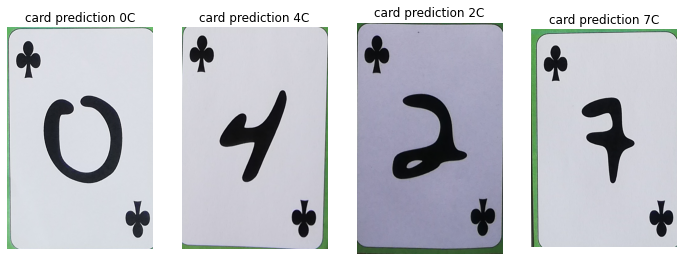

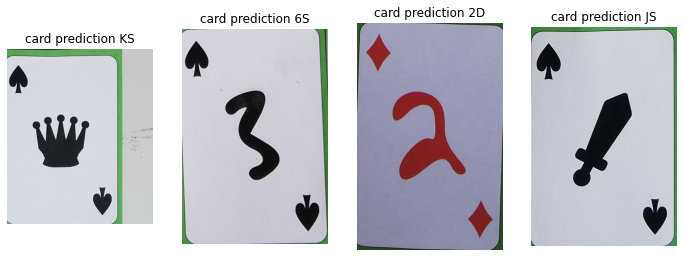

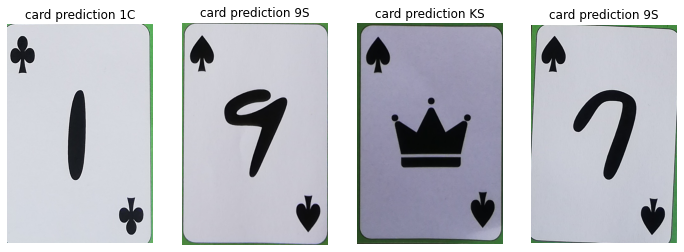

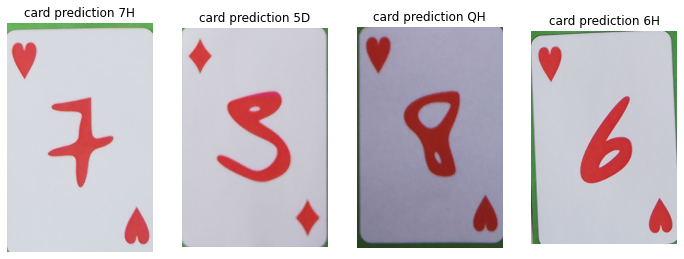

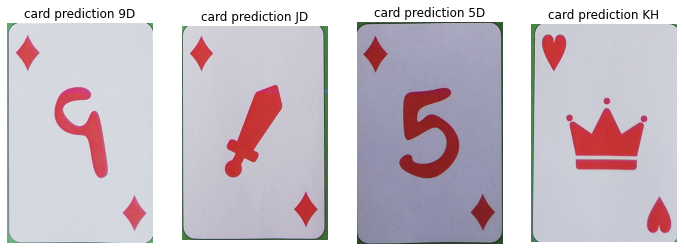

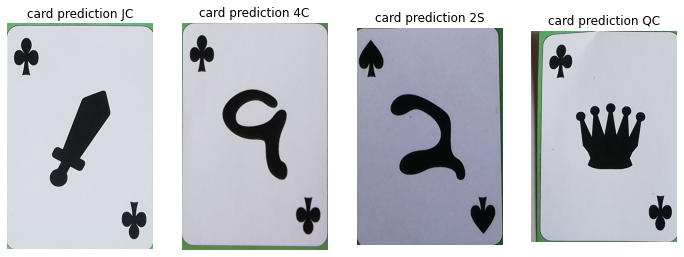

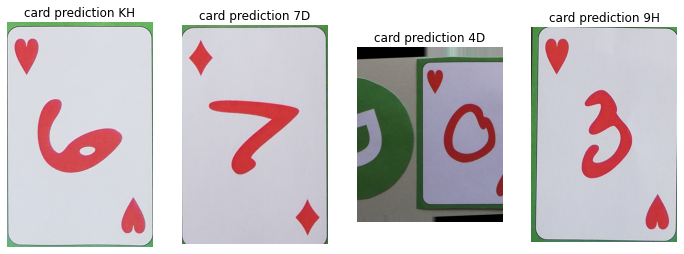

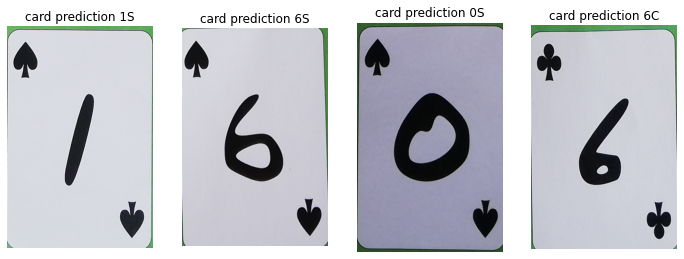

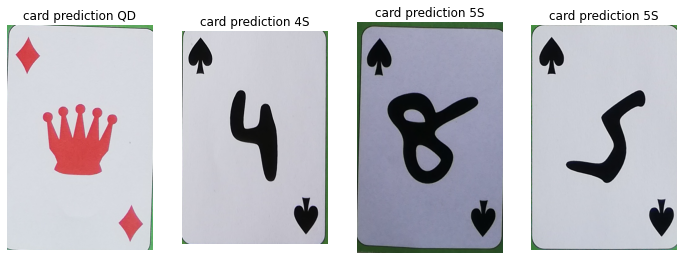

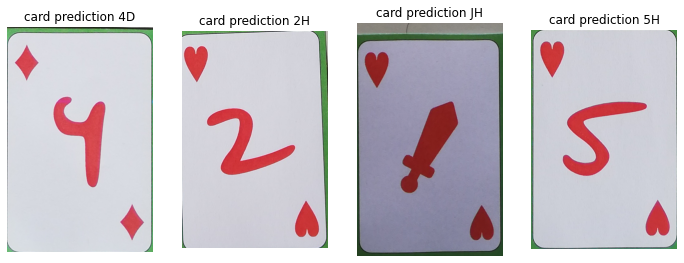

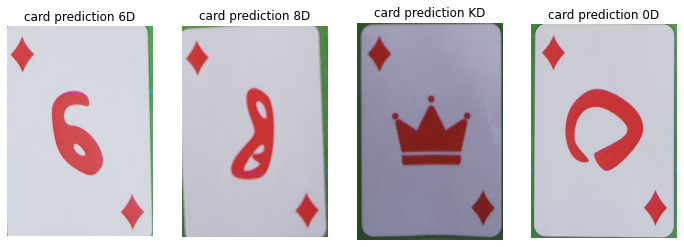

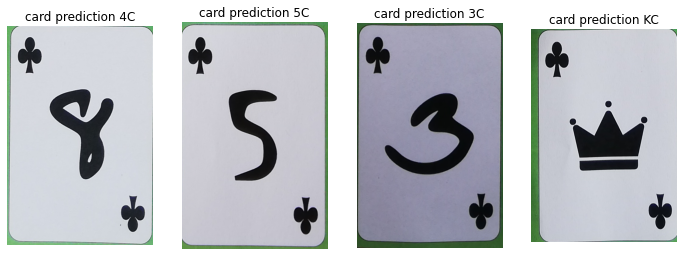

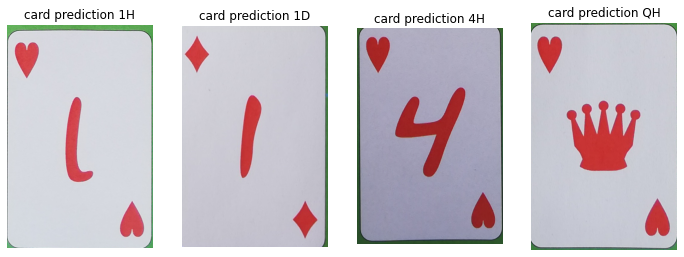

The cards played were:
[
['0C', '4C', '2C', '7C'], 
['KS', '6S', '2D', 'JS'], 
['1C', '9S', 'KS', '9S'], 
['7H', '5D', 'QH', '6H'], 
['9D', 'JD', '5D', 'KH'], 
['JC', '4C', '2S', 'QC'], 
['KH', '7D', '4D', '9H'], 
['1S', '6S', '0S', '6C'], 
['QD', '4S', '5S', '5S'], 
['4D', '2H', 'JH', '5H'], 
['6D', '8D', 'KD', '0D'], 
['4C', '5C', '3C', 'KC'], 
['1H', '1D', '4H', 'QH'], 
]
Players designated as dealer: [2 2 2 2 3 3 2 3 3 4 4 1 1]
Players points (standard): [1. 4. 5. 4.]
Players points (advanced): [3. 1. 4. 6.]


In [22]:
#From oral data
data_base_path = 'oral/'
game = 'game'
nb_digit,digit_names,digit_im=load_image_from_game(game,data_base_path)

#From training data
#game_idx=7
#print('------------------------------------------------- GAME {} -------------------------------------------------'.format(game_idx))
#data_base_path = os.path.join(os.pardir, 'Image_processing/train_games')
#game = 'game{}'.format(game_idx)
#nb_digit,digit_names,digit_im=load_image_from_game(game, data_base_path)

im_h,im_w,_=digit_im[0].shape

#compute contours of card 
cnts=find_cnts(nb_digit,digit_im,disp=False)

#locate_cards dim 
card_pos=compute_card_area(cnts,digit_im,nb_digit,disp=False,disp_dealer=True)

#sorted card by their position
card_pos_sorted=get_players_id(card_pos,im_w,im_h)
#Retrieve only area of interest
retrieved_cards, dealers=retrieve_cards(card_pos_sorted,digit_im,disp=False, disp_dealer=False)

#recompute the contour for each cards
cards_cnts=[]
for idx in range (0,nb_digit):
  cnts=find_cnts(4,retrieved_cards[idx],disp=False, Hough = True)
  cards_cnts.append(cnts)

#get the right orientation and crop the border of the cards image, you can modify size_cropping to set this value
resize_im=compute_min_card_area(cards_cnts,retrieved_cards,size_cropping=75,disp=False,disp_dealer=True)

# predict suits, returns a list of suits
pred_suits = prediction_suit(clf_suit, resize_im)

#get rank symbols
rank_symbols_cnn = get_card_subregion(resize_im, disp=False)
#Flatten the list    
pred_ranks = []
for fold in rank_symbols_cnn:
  for im in fold:
    pred_ranks.append(rank_prediction(model_cnn, im))

#We shifted it since south player is player 1 and not 0
pred_dealers=np.array(dealers)+1
pred_pts_stand, pred_pts_advan, scores_stand, scores_advan=games_scores(pred_ranks, pred_suits, dealers)
card_pred=reshape_prediction(pred_ranks, pred_suits)

for round_idx in range(0,nb_digit):
    fig, ax = plt.subplots(1, 4, figsize=(12, 12))
    for i in range(0,4):
        ax[i].imshow(resize_im[round_idx][i])
        ax[i].set_title('card prediction {}'.format(card_pred[round_idx][i]))
        ax[i].axis('off')
    plt.show()

print_results(
    rank_colour=card_pred, 
    dealer=pred_dealers, 
    pts_standard=pred_pts_advan,
    pts_advanced=pred_pts_stand,
)

Cf [iapr]: https://github.com/LTS5/iapr/blob/master/project/project.ipynb